<a href="https://colab.research.google.com/github/dko1217/DeepLearning-PorousMedia/blob/main/Unet_Unit_Cell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# System Information

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

# Initialize Package

In [ ]:
!pip install hdf5storage

In [ ]:
from hdf5storage import loadmat

import numpy as np
from numpy.random import seed
from numpy.random import default_rng

from matplotlib import pyplot as plt
import os

import scipy
from scipy import io
from scipy.ndimage import zoom
from scipy.stats import ks_2samp

import tensorflow as tf
print('tensorflow version : {}'.format(tf.__version__))
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import save_model

from sklearn.model_selection import train_test_split

seed = 10

tf.random.set_seed(seed)
np.random.seed(seed)

tensorflow version : 2.11.0


In [ ]:
%cd /content/drive/My\ Drive/DarcyUnet Unit Cell/

/content/drive/My Drive/DarcyUnet Unit Cell


# Functions

In [ ]:
def minmax_transform(x, x_min=0, x_range=1):
  x = ( x - x_min ) / x_range
  return x


def shift_augmentation(my_solid, my_vel, shift_range, vel_dir):
  # my_solid : NxNxN
  # my_vel : NxNxN
  # shift_range : 2x1 in voxels
  # vel_dir : string

  # Augmentation placeholder
  my_aug_solid = np.ones_like(my_solid)
  my_aug_vel = np.ones_like(my_vel)

  # Ratio of shift value
  shift_x = shift_range[0]
  shift_y = shift_range[1]
  shift_z = shift_range[2]

  # X Shift
  if(shift_x < 0):
    my_aug_solid[:shift_x,:,:] = my_solid[-1*shift_x:,:,:]
    my_aug_solid[shift_x:,:,:] = np.flip(my_solid, axis=0 )[:-1*shift_x,:,:]

    my_aug_vel[:shift_x,:,:] = my_vel[-1*shift_x:,:,:]
    if(vel_dir[0] == 'x'):
      my_aug_vel[shift_x:,:,:] = np.flip(-1*my_vel, axis=0 )[:-1*shift_x,:,:]
    else:
      my_aug_vel[shift_x:,:,:] = np.flip(my_vel, axis=0 )[:-1*shift_x,:,:]

  elif(shift_x > 0):
    my_aug_solid[:shift_x,:,:] = np.flip(my_solid, axis=0 )[-1*shift_x:,:,:]
    my_aug_solid[shift_x:,:,:] = my_solid[:-1*shift_x,:,:]

    my_aug_vel[shift_x:,:,:] = my_vel[:-1*shift_x,:,:]
    if(vel_dir[0] == 'x'):
      my_aug_vel[:shift_x,:,:] = np.flip(-1*my_vel, axis=0 )[-1*shift_x:,:,:]
    else:
      my_aug_vel[:shift_x,:,:] = np.flip(my_vel, axis=0 )[-1*shift_x:,:,:]

  else:
    my_aug_solid = my_solid
    my_aug_vel = my_vel

  my_solid = my_aug_solid
  my_vel = my_aug_vel

  # Y Shift
  my_aug_solid = np.ones_like(my_solid)
  my_aug_vel = np.ones_like(my_vel)

  if(shift_y < 0):
    my_aug_solid[:,:shift_y,:] = my_solid[:,-1*shift_y:,:]
    my_aug_solid[:,shift_y:,:] = np.flip(my_solid, axis=1 )[:,:-1*shift_y,:]

    my_aug_vel[:,:shift_y,:] = my_vel[:,-1*shift_y:,:]
    if(vel_dir[0] == 'y'):
      my_aug_vel[:,shift_y:,:] = np.flip(-1*my_vel, axis=1 )[:,:-1*shift_y,:]
    else:
      my_aug_vel[:,shift_y:,:] = np.flip(my_vel, axis=1 )[:,:-1*shift_y,:]
      
  elif(shift_y > 0):
    my_aug_solid[:,:shift_y,:] = np.flip(my_solid, axis=1 )[:,-1*shift_y:,:]
    my_aug_solid[:,shift_y:,:] = my_solid[:,:-1*shift_y,:]

    my_aug_vel[:,shift_y:,:] = my_vel[:,:-1*shift_y,:]
    if(vel_dir[0] == 'y'):
      my_aug_vel[:,:shift_y,:] = np.flip(-1*my_vel, axis=1 )[:,-1*shift_y:,:]
    else:
      my_aug_vel[:,:shift_y,:] = np.flip(my_vel, axis=1 )[:,-1*shift_y:,:]

  else:
    my_aug_solid = my_solid
    my_aug_vel = my_vel

  my_solid = my_aug_solid
  my_vel = my_aug_vel
  
  # Z Shift
  my_aug_solid = np.ones_like(my_solid)
  my_aug_vel = np.ones_like(my_vel)

  if(shift_z < 0):
    my_aug_solid[:,:,:shift_z] = my_solid[:,:,-1*shift_z:]
    my_aug_solid[:,:,shift_z:] = np.flip( my_solid, axis=2 )[:,:,:-1*shift_z]

    my_aug_vel[:,:,:shift_z] = my_vel[:,:,-1*shift_z:]
    my_aug_vel[:,:,shift_z:] = np.flip( my_vel, axis=2 )[:,:,:-1*shift_z]

  elif(shift_z > 0):
    my_aug_solid[:,:,:shift_z] = np.flip( my_solid, axis=2 )[:,:,-1*shift_z:]
    my_aug_solid[:,:,shift_z:] = my_solid[:,:,:-1*shift_z]

    my_aug_vel[:,:,:shift_z] = np.flip( my_vel, axis=2 )[:,:,-1*shift_z:]
    my_aug_vel[:,:,shift_z:] = my_vel[:,:,:-1*shift_z]
    
  else:
    my_aug_solid = my_solid
    my_aug_vel = my_vel


  return my_aug_solid, my_aug_vel

# Custom Loss

In [ ]:
def div_loss1(y_true, y_pred):

  scale = 1

  mse = tf.math.reduce_mean( tf.math.square(y_true - y_pred) )
  
  dVxdx_true = (y_true[:,2:,1:-1,1:-1,0] - y_true[:,:-2,1:-1,1:-1,0])/2
  dVydy_true = (y_true[:,1:-1,2:,1:-1,1] - y_true[:,1:-1,:-2,1:-1,1])/2
  dVzdz_true = (y_true[:,1:-1,1:-1,2:,2] - y_true[:,1:-1,1:-1,:-2,2])/2
  div_true = dVxdx_true + dVydy_true + dVzdz_true

  dVxdx_pred = (y_pred[:,2:,1:-1,1:-1,0] - y_pred[:,:-2,1:-1,1:-1,0])/2
  dVydy_pred = (y_pred[:,1:-1,2:,1:-1,1] - y_pred[:,1:-1,:-2,1:-1,1])/2
  dVzdz_pred = (y_pred[:,1:-1,1:-1,2:,2] - y_pred[:,1:-1,1:-1,:-2,2])/2
  div_pred = dVxdx_pred + dVydy_pred + dVzdz_pred

  div_loss = tf.math.reduce_mean( tf.math.abs(div_true - div_pred) )

  loss = mse + div_loss*scale
  
  return loss


def div_loss2(y_true, y_pred):

  scale = 5

  mse = tf.math.reduce_mean( tf.math.square(y_true - y_pred) )
  
  dVxdx_pred = (y_pred[:,2:,1:-1,1:-1,0] - y_pred[:,:-2,1:-1,1:-1,0])/2
  dVydy_pred = (y_pred[:,1:-1,2:,1:-1,1] - y_pred[:,1:-1,:-2,1:-1,1])/2
  dVzdz_pred = (y_pred[:,1:-1,1:-1,2:,2] - y_pred[:,1:-1,1:-1,:-2,2])/2
  div_pred = dVxdx_pred + dVydy_pred + dVzdz_pred

  div_loss = tf.math.reduce_mean( tf.math.abs(div_pred) )

  loss = mse + div_loss*scale
  
  return loss

# Input Parameter

In [ ]:
# Model A-Z1 / A-X1
#domainType_ls4 = ['SCC', 'BCC', 'FCC', 'TCC']
#domainRange_ls4 = [ range(1,11), range(1,11), range(1,11), range(1,11)]

# Model B-Z1 / B-X1
domainType_ls4 = ['SCC', 'BCC', 'FCC', 'TCC', 'CaF2', 'CaTiO3', 'CsCl', 'NaCl']
domainRange_ls4 = [ range(1,11), range(1,11), range(1,11), range(1,11), range(1,11), range(1,11), range(1,11), range(1,11)]

# Model C-Z1
#domainType_ls4 = ['SCC', 'BCC', 'FCC', 'TCC']
#domainRange_ls4 = [ range(2,11),  [2,3,4,7,8,10], [2,3,5,6,7,8,9,10], [1,2,3,6,7,8,9,10] ]

#domainType_ls2 = ['SCC', 'BCC', 'FCC', 'TCC']
#domainRange_ls2 = [ [1,2,3,4,5,6,7,9,10], [1,2,3,4,6,7,8,10], range(1,11), [1,2,5,6,7,8,9,10] ]

# Model D-Z1
#domainType_ls4 = ['SCC', 'BCC', 'FCC', 'TCC', 'CaF2', 'CaTiO3', 'CsCl', 'NaCl']
#domainRange_ls4 = [ range(2,11),  [2,3,4,7,8,10], [2,3,5,6,7,8,9,10], [1,2,3,6,7,8,9,10], [1,2,3,4,5,6,7,8,10], [1,2,3,4,5,6,7,9,10], [1,3,4,5,6,7,8,10], range(1,10)]

#domainType_ls2 = ['SCC', 'BCC', 'FCC', 'TCC', 'CaF2', 'CaTiO3', 'CsCl', 'NaCl']
#domainRange_ls2 = [ [1,2,3,4,5,6,7,9,10], [1,2,3,4,6,7,8,10], range(1,11), [1,2,5,6,7,8,9,10], range(1,11), [1,2,3,4,5,6,7,8,10], range(1,11), range(1,11)]

# Model E-X1
#domainType_ls2 = ['SCC', 'BCC', 'FCC', 'TCC']
#domainRange_ls2 = [ range(2,11),  [2,3,4,7,8,10], [2,3,5,6,7,8,9,10], [1,2,3,6,7,8,9,10] ]

#domainType_ls1 = ['SCC', 'BCC', 'FCC', 'TCC']
#domainRange_ls1 = [ [1,2,3,4,5,6,7,9,10], [1,2,3,4,6,7,8,10], range(1,11), [1,2,5,6,7,8,9,10] ]

# Model F-X1
#domainType_ls2 = ['SCC', 'BCC', 'FCC', 'TCC', 'CaF2', 'CaTiO3', 'CsCl', 'NaCl']
#domainRange_ls2 = [ range(2,11),  [2,3,4,7,8,10], [2,3,5,6,7,8,9,10], [1,2,3,6,7,8,9,10], [1,2,3,4,5,6,7,8,10], [1,2,3,4,5,6,7,9,10], [1,3,4,5,6,7,8,10], range(1,10)]

#domainType_ls1 = ['SCC', 'BCC', 'FCC', 'TCC', 'CaF2', 'CaTiO3', 'CsCl', 'NaCl']
#domainRange_ls1 = [ [1,2,3,4,5,6,7,9,10], [1,2,3,4,6,7,8,10], range(1,11), [1,2,5,6,7,8,9,10], range(1,11), [1,2,3,4,5,6,7,8,10], range(1,11), range(1,11)]


# Velocity direction
channel = 2
data_size = 128


# Normalization
x_min = 0

if channel < 2:
  x_max = 1.6e-9
else:
  x_max = 3e-9

res_rs = 18.75e-6
res_uc = 160e-6


# Augmentation
rotation = 90
shift = 1/2

aug_sample_total = 240

val_perc = 0.1
test_perc = 0.1

# Unit Cell Data

## Import data

In [ ]:
# length scale X4
dir_data = 'Data/UnitCell'

uc_solid_ls4 = np.zeros( (1,data_size, data_size, data_size) )
uc_vel_ls4 = np.zeros( (1,data_size, data_size, data_size) )

for i in range(len(domainType_ls4)):
    for j in domainRange_ls4[i]:

      uc_solid_load = loadmat( f'{dir_data}/{domainType_ls4[i]}_domain{j}_solid.mat' )['solid'].astype('int')
      uc_solid_ls4 = np.append( uc_solid_ls4, np.expand_dims(uc_solid_load, axis=0), axis=0 )
      del uc_solid_load

      uc_vel_load = loadmat( f'{dir_data}/{domainType_ls4[i]}_domain{j}_vfield.mat' )['vfield'].astype('float32')
      uc_vel_ls4 = np.append( uc_vel_ls4, np.expand_dims(uc_vel_load[:,:,:,channel], axis=0), axis=0 )
      del uc_vel_load

uc_solid_ls4 = uc_solid_ls4[1:,:,:,:]
uc_vel_ls4 = uc_vel_ls4[1:,:,:,:]

print(f'Solid data : {uc_solid_ls4.shape}\nVelocity data : {uc_vel_ls4.shape}')

In [ ]:
# Length scale X2
dir_data = 'Data/UnitCell'

uc_solid_ls2 = np.zeros( (1,data_size, data_size, data_size) )
uc_vel_ls2 = np.zeros( (1,data_size, data_size, data_size) )

for i in range(len(domainType_ls2)):
    for j in domainRange_ls2[i]:

      uc_solid_load = loadmat( f'{dir_data}/{domainType_ls2[i]}_domain{j}_solid.mat' )['solid'].astype('int')
      uc_solid_ls2 = np.append( uc_solid_ls2, np.expand_dims(uc_solid_load, axis=0), axis=0 )
      del uc_solid_load

      uc_vel_load = loadmat( f'{dir_data}/{domainType_ls2[i]}_domain{j}_vfield.mat' )['vfield'].astype('float32')
      uc_vel_ls2 = np.append( uc_vel_ls2, np.expand_dims(uc_vel_load[:,:,:,channel], axis=0), axis=0 )
      del uc_vel_load

uc_solid_ls2 = uc_solid_ls2[1:,:,:,:]
uc_vel_ls2 = uc_vel_ls2[1:,:,:,:]

print(f'Solid data : {uc_solid_ls2.shape}\nVelocity data : {uc_vel_ls2.shape}')

In [ ]:
# Length scale X1
dir_data = 'Data/UnitCell'

uc_solid_ls1 = np.zeros( (1,data_size, data_size, data_size) )
uc_vel_ls1 = np.zeros( (1,data_size, data_size, data_size) )

for i in range(len(domainType_ls1)):
    for j in domainRange_ls1[i]:

      uc_solid_load = loadmat( f'{dir_data}/{domainType_ls1[i]}_domain{j}_solid.mat' )['solid'].astype('int')
      uc_solid_ls1 = np.append( uc_solid_ls1, np.expand_dims(uc_solid_load, axis=0), axis=0 )
      del uc_solid_load

      uc_vel_load = loadmat( f'{dir_data}/{domainType_ls1[i]}_domain{j}_vfield.mat' )['vfield'].astype('float32')
      uc_vel_ls1 = np.append( uc_vel_ls1, np.expand_dims(uc_vel_load[:,:,:,channel], axis=0), axis=0 )
      del uc_vel_load

uc_solid_ls1 = uc_solid_ls1[1:,:,:,:]
uc_vel_ls1 = uc_vel_ls1[1:,:,:,:]

print(f'Solid data : {uc_solid_ls1.shape}\nVelocity data : {uc_vel_ls1.shape}')

## Normalization

In [ ]:
# Raw Velocity normalization to Random Sphere Length Scale
# Length scale X4

uc_vel_norm_ls4 = minmax_transform( uc_vel_ls4*(res_rs**2)/( (res_uc/1)**2 )*0.1/1000, x_min=x_min, x_range=x_max-x_min )
print(f'Mean velocity Length scale X4 : {uc_vel_norm_ls4.mean()}')

In [ ]:
# Raw Velocity normalization to Random Sphere Length Scale
# Length scale X2

uc_vel_norm_ls2 = minmax_transform( uc_vel_ls2*(res_rs**2)/( (res_uc/2)**2 )*0.1/1000, x_min=x_min, x_range=x_max-x_min )
print(f'Mean velocity Length scale X2 : {uc_vel_norm_ls2.mean()}')

In [ ]:
# Raw Velocity normalization to Random Sphere Length Scale
# Length scale X1

uc_vel_norm_ls1 = minmax_transform( uc_vel_ls1*(res_rs**2)/( (res_uc/4)**2 )*0.1/1000, x_min=x_min, x_range=x_max-x_min )
print(f'Mean velocity Length scale X1 : {uc_vel_norm_ls1.mean()}')

## Length Scale

In [ ]:
# Zoom augmentation to create different length scale
# Length scale X4

for i in range(uc_solid_ls4.shape[0]):

  solid_zoom_temp = zoom( uc_solid_ls4[i,:,:,:], (1/4,1/4,1/4) )
  vel_zoom_temp = zoom( uc_vel_norm_ls4[i,:,:,:], (1/4,1/4,1/4) )

  uc_solid_ls4[i,:,:,:] = np.tile( solid_zoom_temp, (4,4,4) )
  uc_vel_norm_ls4[i,:,:,:] = np.tile( vel_zoom_temp, (4,4,4) )

uc_solid_ls4 = np.around(uc_solid_ls4)

print(f'Solid data : {uc_solid_ls4.shape}\nVelocity data : {uc_vel_norm_ls4.shape}')

In [ ]:
# Zoom augmentation to create different length scale
# Length scale X2

for i in range(uc_solid_ls2.shape[0]):

  solid_zoom_temp = zoom( uc_solid_ls2[i,:,:,:], (1/2, 1/2, 1/2) )
  vel_zoom_temp = zoom( uc_vel_norm_ls2[i,:,:,:], (1/2, 1/2, 1/2) )

  uc_solid_ls2[i,:,:,:] = np.tile( solid_zoom_temp, (2, 2, 2) )
  uc_vel_norm_ls2[i,:,:,:] = np.tile( vel_zoom_temp, (2, 2, 2) )

uc_solid_ls2 = np.around(uc_solid_ls2)

print(f'Solid data : {uc_solid_ls2.shape}\nVelocity data : {uc_vel_norm_ls2.shape}')

## Augmentation

In [ ]:
# Combine Length scale data

uc_solid_data = np.zeros( (1,data_size, data_size, data_size) )
uc_vel_data = np.zeros( (1,data_size, data_size, data_size) )

try:
  uc_solid_data = np.append(uc_solid_data, uc_solid_ls4, axis=0)
  uc_vel_data = np.append(uc_vel_data, uc_vel_norm_ls4, axis=0)
except NameError:
  print('No Length scale X4 data')

try:
  uc_solid_data = np.append(uc_solid_data, uc_solid_ls2, axis=0)
  uc_vel_data = np.append(uc_vel_data, uc_vel_norm_ls2, axis=0)
except NameError:
  print('No Length scale X2 data')

try:
  uc_solid_data = np.append(uc_solid_data, uc_solid_ls1, axis=0)
  uc_vel_data = np.append(uc_vel_data, uc_vel_norm_ls1, axis=0)
except NameError:
  print('No Length scale X1 data')

uc_solid_data = uc_solid_data[1:,:,:,:]
uc_vel_data = uc_vel_data[1:,:,:,:]

print(f'\nSolid data : {uc_solid_data.shape}\nVelocity data : {uc_vel_data.shape}')

In [ ]:
# AUGMENTATION WITH IMAGE DATA GENERATOR

aug_Generator = ImageDataGenerator(rotation_range = rotation, 
                                 width_shift_range = shift,
                                 height_shift_range = shift,
                                 fill_mode='wrap')

solid_iterator = aug_Generator.flow(uc_solid_data, seed=seed, batch_size = uc_solid_data.shape[0])
vel_iterator = aug_Generator.flow(uc_vel_data, seed=seed, batch_size = uc_vel_data.shape[0])

aug_solid = np.zeros( (1, data_size, data_size, data_size) )
aug_vel = np.zeros( (1, data_size, data_size, data_size) )

while aug_solid.shape[0] < aug_sample_total:
  aug_solid = np.append(aug_solid, solid_iterator.next(), axis=0) 
  aug_vel = np.append(aug_vel, vel_iterator.next(), axis=0)

aug_solid = aug_solid[1:,:,:,:]
aug_vel = aug_vel[1:,:,:,:]

aug_solid = np.expand_dims(aug_solid, axis=-1)
aug_vel = np.expand_dims(aug_vel, axis=-1)

print(f'Solid data : {aug_solid.shape}\nVelocity data : {aug_vel.shape}')

In [ ]:
total_number = aug_solid.shape[0]

train_index, val_test_index = train_test_split(np.arange(total_number), test_size = val_perc + test_perc, random_state=seed)
val_index, test_index = train_test_split(val_test_index, test_size = test_perc/(val_perc+test_perc), random_state=seed)

print(f'Number of training samples : {len(train_index)}')
print(f'Number of validation samples : {len(val_index)}')
print(f'Number of test samples : {len(test_index)}')

train_data_solid = aug_solid[train_index]
val_data_solid = aug_solid[val_index]
test_data_solid = aug_solid[test_index]

train_data_vel = aug_vel[train_index]
val_data_vel = aug_vel[val_index]
test_data_vel = aug_vel[test_index]

# Data Check

In [ ]:
# Raw data - XY Plane
sample_number = 1

slice = np.array( [31, 63, 95] )
fig_title = ['Quarter inlet', 'Midpoint', 'Quarter outlet']

fig, axs = plt.subplots( nrows=2, ncols=3,figsize=(10,10) )

vel_mag = (0,3)

for j in np.array( [0, 1, 2] ):
  im=axs[0,j].imshow(uc_solid_ls1[sample_number,:,:,slice[j]], clim=(0,1), cmap=plt.cm.hot)
  fig.colorbar(im,ax=axs[0,j],fraction=0.05)
  axs[0,j].axis('off')

  im=axs[1,j].imshow(uc_vel_norm_ls1[sample_number,:,:,slice[j]], clim=vel_mag, cmap=plt.cm.hot)
  fig.colorbar(im,ax=axs[1,j],fraction=0.05)
  axs[1,j].axis('off')

In [ ]:
# Raw data - YZ Plane
sample_number = 1

slice = np.array( [0, 63, 95] )
fig_title = ['Quarter inlet', 'Midpoint', 'Quarter outlet']

fig, axs = plt.subplots( nrows=2, ncols=3,figsize=(10,10) )

vel_mag = (0,3)

for j in np.array( [0, 1, 2] ):
  im=axs[0,j].imshow(np.squeeze(uc_solid_ls1[sample_number,slice[j],:,:]), clim=(0,1), cmap=plt.cm.hot)
  fig.colorbar(im,ax=axs[0,j],fraction=0.05)
  axs[0,j].axis('off')

  im=axs[1,j].imshow(np.squeeze(uc_vel_norm_ls1[sample_number,slice[j],:,:]), clim=vel_mag, cmap=plt.cm.hot)
  fig.colorbar(im,ax=axs[1,j],fraction=0.05)
  axs[1,j].axis('off')

In [ ]:
# Training data
sample_number = 21

slice = np.array( [0, 59, -1] )
fig_title = ['Inlet', 'Midpoint', 'Outlet']

fig, axs = plt.subplots( nrows=2, ncols=3,figsize=(10,10) )

vel_mag = (-1,1)

for j in np.array( [0, 1, 2] ):
  im=axs[0,j].imshow(test_data_solid[sample_number,:,:,slice[j],0], clim=(0,1), cmap=plt.cm.hot)
  fig.colorbar(im,ax=axs[0,j],fraction=0.05)
  axs[0,j].axis('off')
  axs[0,j].set_title('%s Solid' % (fig_title[j]))

  im=axs[1,j].imshow(test_data_vel[sample_number,:,:,slice[j],0], clim=(vel_mag[0],vel_mag[1]), cmap=plt.cm.hot)
  fig.colorbar(im,ax=axs[1,j],fraction=0.05)
  axs[1,j].axis('off')
  axs[1,j].set_title('%s Velocity' % (fig_title[j]))

# Darcy Unet Training

## Unet Model

In [ ]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import Input, Conv3D, Conv3DTranspose, BatchNormalization, Activation, Concatenate, Dropout, Multiply

from numpy import floor, ceil

def encoder_block(inputs, strides, filter_num, filter_size, activation, momentum, rate):

  path = Conv3D(filter_num, filter_size, padding='same', strides=strides)(inputs)
  path = BatchNormalization(momentum=momentum)(path)
  path = Activation(activation=activation)(path)
  path = Dropout(rate)(path)

  return path


def decoder_block(inputs, strides, filter_num, filter_size, activation, momentum, rate):

  path = Conv3DTranspose(filter_num, filter_size, padding='same', strides=strides)(inputs)
  path = BatchNormalization(momentum=momentum)(path)
  path = Activation(activation=activation)(path)
  path = Dropout(rate)(path)

  return path

# U-Net
def UnetV1(input_shape, filter_num = 5, filter_size = 3, activation = 'selu', momentum = 0.99, rate = 0.2, output_dim=3):

  inputs = Input(shape = input_shape)

  skip_connection = []

  for i in range(8):
    
    if(i <= 0):
      path_encoder = encoder_block(inputs, 1, filter_num*(2**floor(i/2)), filter_size, activation, momentum, rate)
    else:

      if(i % 2 == 1):
        path_encoder = encoder_block(path_encoder, 1, filter_num*(2**floor(i/2)), filter_size, activation, momentum, rate)
        skip_connection.append(path_encoder)
      else:
        path_encoder = encoder_block(path_encoder, 2, filter_num*(2**floor(i/2)), filter_size, activation, momentum, rate)

  for i in reversed(range(6)):

    if(i >= 5):
      path_decoder = decoder_block(path_encoder, 2, filter_num*(2**floor(i/2)), filter_size, activation, momentum, rate)
      path_decoder = Concatenate()([ path_decoder, skip_connection[int(floor(i/2))] ])
    else:

      if(i % 2 == 0):
        path_decoder = decoder_block(path_decoder, 1, filter_num*(2**floor(i/2)), filter_size, activation, momentum, rate)
      else:
        path_decoder = decoder_block(path_decoder, 2, filter_num*(2**floor(i/2)), filter_size, activation, momentum, rate)
        path_decoder = Concatenate()([ path_decoder, skip_connection[int(floor(i/2))] ])


  path = Conv3D(filter_num, filter_size, padding='same')(path_decoder)
  path = Conv3D(output_dim, 1, padding='same')(path)

  return Model(inputs=inputs, outputs=path)


# U-Net Comprehensive model
def UnetV2(input_shape, x_model, y_model, z_model, v_scale, filter_num = 5, filter_size = 3, activation = 'selu', momentum = 0.99, rate = 0.2, output_dim=3):
  
  inputs = Input(shape = input_shape)

  x_input = tf.math.multiply( x_model(inputs, training=False), v_scale )
  y_input = tf.math.multiply( y_model(inputs, training=False), v_scale )
  z_input = z_model(inputs, training=False)

  path = Concatenate()( [x_input, y_input, z_input] )

  skip_connection = []

  for i in range(8):
  
    if(i <= 0):
      path_encoder = encoder_block(path, 1, filter_num, filter_size, activation, momentum, rate)
    else:

      if(i % 2 == 1):
        path_encoder = encoder_block(path_encoder, 1, filter_num, filter_size, activation, momentum, rate)
        skip_connection.append(path_encoder)
      else:
        path_encoder = encoder_block(path_encoder, 2, filter_num, filter_size, activation, momentum, rate)

  for i in reversed(range(6)):

    if(i >= 5):
      path_decoder = decoder_block(path_encoder, 2, filter_num, filter_size, activation, momentum, rate)
      path_decoder = Concatenate()([ path_decoder, skip_connection[int(floor(i/2))] ])
    else:

      if(i % 2 == 0):
        path_decoder = decoder_block(path_decoder, 1, filter_num, filter_size, activation, momentum, rate)
      else:
        path_decoder = decoder_block(path_decoder, 2, filter_num, filter_size, activation, momentum, rate)
        path_decoder = Concatenate()([ path_decoder, skip_connection[int(floor(i/2))] ])


  path = Conv3D(filter_num, filter_size, padding='same')(path_decoder)
  path = Conv3D(output_dim, 1, padding='same')(path)

  return Model(inputs=inputs, outputs=path)

# 1 layer convolution
def UnetV3(input_shape, x_model, y_model, z_model, v_scale, filter_num = 5, filter_size = 3, activation = 'selu', momentum = 0.99, rate = 0.2, output_dim=3):

  inputs = Input(shape = input_shape)

  x_input = tf.math.multiply( x_model(inputs, training=False), v_scale )
  y_input = tf.math.multiply( y_model(inputs, training=False), v_scale )
  z_input = z_model(inputs, training=False)

  path = Concatenate()( [x_input, y_input, z_input] )

  for i in range(3):
    path = encoder_block(path, 1, filter_num, filter_size, activation, momentum, rate)

  path = Conv3D(output_dim, 1, padding='same')(path)

  return Model(inputs=inputs, outputs=path)

# Multi-scale Model
def UnetV4(input_shape, x_model, y_model, z_model, v_scale, filter_num = 5, filter_size = (3,5,7), num_layers=3, activation = 'selu', momentum = 0.99, rate = 0.2, output_dim=3):

  inputs = Input(shape = input_shape)

  x_input = tf.math.multiply( x_model(inputs, training=False), v_scale )
  y_input = tf.math.multiply( y_model(inputs, training=False), v_scale )
  z_input = z_model(inputs, training=False)

  path = Concatenate()( [x_input, y_input, z_input] )

  path_small = path
  path_medium = path
  path_large = path

  for i in range(num_layers):
    path_small = encoder_block(path_small, 1, filter_num, filter_size[0], activation, momentum, rate)
    path_medium = encoder_block(path_medium, 1, filter_num, filter_size[1], activation, momentum, rate)
    path_large = encoder_block(path_large, 1, filter_num, filter_size[2], activation, momentum, rate)

  path = Concatenate()( [path_small, path_medium, path_large] )
  path = Conv3D(output_dim, 1, padding='same')(path)

  return Model(inputs=inputs, outputs=path)

## Model Training

In [ ]:
version = 'C-Z2'

model_name = f'UnetUC_{version}'
dir_save   = f'UnitCell SubModel/{model_name}'

try:
  os.mkdir(dir_save)
except OSError:
  print('Path already exists')

filter_size = 4
num_filters = 10

learning_rate = 0.00007
batch_size = 4

momentum = 0.99
rate = 0.05

epochs = 1000
patience_training = 50

activation = 'relu'

metrics=['MAE', 'MSE']
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

model = UnetV1( input_shape = (data_size, data_size, data_size, 1), filter_num = num_filters, filter_size = filter_size, activation = activation, 
               momentum = momentum, rate = rate, output_dim=1)

model.compile( loss = tf.keras.losses.mean_squared_error, optimizer=optimizer, metrics=metrics[:] )

nan_terminate = tf.keras.callbacks.TerminateOnNaN()
early_stop    = tf.keras.callbacks.EarlyStopping(monitor ='val_loss', min_delta = 0,
                                              patience = patience_training, 
                                              verbose = True, mode = 'auto', baseline = None)

csv_logger = tf.keras.callbacks.CSVLogger("{}/training_log_{}.csv".format(dir_save,model_name))

checkpoint = ModelCheckpoint('{}/{}.ckpt'.format(dir_save,model_name), 
                             monitor = 'val_loss', 
                             verbose = 1, 
                             save_best_only = True, 
                             mode = 'min', save_weights_only = False)

callbacks_list = [nan_terminate, early_stop, checkpoint, csv_logger]

print('Model ready')      

In [ ]:
model.summary(line_length = 250)

In [ ]:
from keras.utils.vis_utils import plot_model

imgtype = ('LR','TB')
for i in imgtype:
  plot_model(model, to_file='UnitCell SubModel/Model Image/{}_{}.jpg'.format(model_name, i), rankdir = i, show_layer_names = False)

In [ ]:
from timeit import default_timer as timer
from datetime import timedelta

start = timer()

model.fit( x = train_data_solid, y = train_data_vel, 
           epochs = epochs, batch_size = batch_size,
           validation_data = (val_data_solid, val_data_vel),
           validation_freq = 1,
           verbose = 1,
           callbacks = callbacks_list)

end = timer()
print('Elapsed time for training : {}'.format(timedelta(seconds=end-start)))

best_model = tf.keras.models.load_model( '{}/{}.ckpt'.format(dir_save, model_name) )
best_model.save(dir_save)

print('Training complete : {}'.format(version))

In [ ]:
best_model = tf.keras.models.load_model( '{}/{}.ckpt'.format(dir_save, model_name) )
best_model.save(dir_save)

## Model Evaluation

In [ ]:
version = 'A-Z1'

eval_model_name = f'UnetUC_{version}'
eval_model = tf.keras.models.load_model( f'UnitCell SubModel/{eval_model_name}/' )
#eval_model = tf.keras.models.load_model( f'UnitCell SubModel/{eval_model_name}/', custom_objects = {'div_loss2': div_loss2} )

metric_evaluate = eval_model.evaluate(test_data_solid, test_data_vel)

vz_test_pred = np.float32( eval_model.predict( x=[test_data_solid] ) )

print(vz_test_pred.shape)

In [ ]:
# Overall Permeability
channel = 2

perm_true = test_data_vel[:,:,:,:,channel].mean(axis=(1,2,3))
perm_pred = vz_test_pred[:,:,:,:,channel].mean(axis=(1,2,3))

perm_error = abs( perm_true - perm_pred )/abs(perm_true)*100

print( 'Overall permeability error : {:.3f}\n'.format(perm_error.mean()) )

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(perm_error.shape[0]), perm_error)
plt.title('Permeability Error')
plt.show()

In [ ]:
# Velocity PDF

channel = 2

min = 0.001
max = 120
numbin = 400

vel_true_flat = np.abs( (test_data_vel[:,:,:,:,channel]).flatten() )
vel_pred_flat = np.abs( (vz_test_pred[:,:,:,:,channel]).flatten() )

vel_true_flat_nz = vel_true_flat[ (vel_true_flat > min) & (vel_pred_flat > min) ]
vel_pred_flat_nz = vel_pred_flat[ (vel_true_flat > min) & (vel_pred_flat > min) ]
vel_true_flat_nz_mean = vel_true_flat_nz.mean()

#log_bins = np.logspace(np.log10(min), np.log10(max), numbin)
log_bins = np.linspace(min, max, numbin)

true_hist = plt.hist( vel_true_flat_nz, bins=log_bins, density=True, histtype='step', label='true' )
pred_hist = plt.hist( vel_pred_flat_nz, bins=log_bins, density=True, histtype='step', label='pred' )
plt.axvline(vel_true_flat_nz.mean(), color='k', linestyle='dashed', linewidth=1)
plt.legend()

#plt.xscale('log')
plt.yscale('log')

plt.show()

th_value = 0.1
threshold = vel_true_flat_nz_mean*th_value
vel_true_flat_nz_th = vel_true_flat_nz[ vel_true_flat_nz > threshold]
vel_pred_flat_nz_th = vel_pred_flat_nz[ vel_true_flat_nz > threshold]

mape_th = np.divide( np.abs(vel_true_flat_nz_th - vel_pred_flat_nz_th), vel_true_flat_nz_th).mean()*100

print(mape_th)

th_value = 1
threshold = vel_true_flat_nz_mean*th_value
vel_true_flat_nz_th = vel_true_flat_nz[ vel_true_flat_nz > threshold]
vel_pred_flat_nz_th = vel_pred_flat_nz[ vel_true_flat_nz > threshold]

mape_th = np.divide( np.abs(vel_true_flat_nz_th - vel_pred_flat_nz_th), vel_true_flat_nz_th).mean()*100

print(mape_th)

In [ ]:
channel = 2

min = 0.001
max = 20

vel_true_indflat = np.abs( test_data_vel[:,:,:,:,channel].reshape(len(test_index), 128**3) )
vel_pred_indflat = np.abs( vz_test_pred[:,:,:,:,channel].reshape(len(test_index), 128**3) )

vel_true_indflat_nz = np.ma.masked_less(vel_true_indflat, min)
vel_pred_indflat_nz = np.ma.masked_less(vel_pred_indflat, min)
vel_true_indflat_nz_mean = vel_true_indflat_nz.mean()
vel_true_indflat_nz_indmean = vel_true_indflat_nz.mean(axis=1)
print(vel_true_indflat_nz_indmean)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(vel_true_indflat_nz_indmean.shape[0]), vel_true_indflat_nz_indmean)
plt.title('Permeability Error')
plt.show()

th_value = 0.01
threshold = vel_true_indflat_nz_mean*th_value
print(threshold)

vel_true_indflat_nz_th = np.ma.masked_less(vel_true_indflat_nz, threshold)
vel_pred_indflat_nz_th = np.ma.masked_less(vel_pred_indflat_nz, threshold)
mape_th = np.divide( np.abs(vel_true_indflat_nz_th - vel_pred_indflat_nz_th), vel_true_indflat_nz_th).mean(axis=1)*100

print(mape_th)

In [ ]:
test_sample = 0
channel = 2

print( 'Maximum Sample Number : {}'.format(test_data_solid.shape[0] - 1) )

mySolid = test_data_solid[test_sample,:,:,:,0]
mySolid_mask = np.ma.masked_less(mySolid, 0.5)

myVel_true = test_data_vel[test_sample,:,:,:,channel]
myVel_true = np.ma.array( myVel_true, mask=np.ma.getmask(mySolid_mask) )

myVel_pred = vz_test_pred[test_sample,:,:,:,channel]
myVel_pred = np.ma.array( myVel_pred, mask=np.ma.getmask(mySolid_mask) )


test_slice = np.array( [0, data_size//2, 72] )
fig_title = ['Inlet', 'Midpoint', 'Outlet']

fig, axs = plt.subplots( nrows=3, ncols=3,figsize=(20,20) )

vel_range = (0,30)

for j in range(3):

  im=axs[j,0].imshow(mySolid[:,:,test_slice[j]], clim=(0,1), cmap=plt.cm.hot)
  fig.colorbar(im,ax=axs[j,0],fraction=0.05)
  axs[j,0].axis('off')
  #axs[j,0].set_title('{} Solid'.format(fig_title[j]))

  im=axs[j,1].imshow(myVel_true[:,:,test_slice[j]], clim=vel_range, cmap=plt.cm.hot)
  fig.colorbar(im,ax=axs[j,1],fraction=0.05)
  axs[j,1].axis('off')
  #axs[j,1].set_title('{} Simulation'.format(fig_title[j]))

  im=axs[j,2].imshow(myVel_pred[:,:,test_slice[j]], clim=vel_range, cmap=plt.cm.hot)
  fig.colorbar(im,ax=axs[j,2],fraction=0.05)
  axs[j,2].axis('off')
  #axs[j,2].set_title('{} Prediction'.format(fig_title[j]))

# PolySphere Data

In [ ]:
dir_data = 'Data/UnitCell/PolySphere validation'

domainRange = [1,2,3,4,5,6,7,8,9]

rs_solid = np.zeros( (1, data_size, data_size, data_size) )
rs_vel = np.zeros( (1, data_size, data_size, data_size) )

for i in domainRange:
  
    rs_solid_load = loadmat( '{}/PolySphere_domain{}_solid.mat'.format(dir_data, i) )['solid'].astype('int')
    rs_solid = np.append( rs_solid, np.expand_dims(rs_solid_load, axis=0), axis=0 )
    del rs_solid_load

    rs_vel_load = loadmat( '{}/PolySphere_domain{}_vfield.mat'.format(dir_data, i) )['vfield'].astype('float32')
    rs_vel = np.append( rs_vel, np.expand_dims(rs_vel_load[:,:,:,channel], axis=0), axis=0 )
    del rs_vel_load

rs_solid = rs_solid[1:,:,:,:]
rs_vel = rs_vel[1:,:,:,:]

rs_solid = np.expand_dims(rs_solid,axis=-1)
rs_vel = np.expand_dims(rs_vel,axis=-1)

print(f'Solid data : {rs_solid.shape}\nVelocity data : {rs_vel.shape}')

In [ ]:
# Raw Velocity Normalization

rs_vel_norm = rs_vel*0.333/9270

rs_vel_norm = minmax_transform(rs_vel_norm, x_min=x_min, x_range=x_max-x_min)

print(f'Mean velocity Random Sohere : {rs_vel_norm.mean()}')

In [ ]:
# Predict velocity 
version = 'D-Z1'

eval_model_name = f'UnetUC_{version}'
eval_model = tf.keras.models.load_model( f'UnitCell SubModel/{eval_model_name}' )

metric_evaluate = eval_model.evaluate(rs_solid, rs_vel_norm)

vz_test_pred = np.float32( eval_model.predict( x=[rs_solid] ) )

print(vz_test_pred.shape)

In [ ]:
# Predict Y velocity using X model

version = 'F-X1'

rs_solid_xtoy = np.rot90(rs_solid, axes=(1,2))

eval_model_name = f'UnetUC_{version}'
eval_model = tf.keras.models.load_model( f'UnitCell SubModel/{eval_model_name}' )

vz_test_pred_xtoy = np.float32( eval_model.predict( x=[rs_solid_xtoy] ) )

vz_test_pred = np.rot90(vz_test_pred_xtoy*-1, 3, axes=(1,2))

print(vz_test_pred.shape)

In [ ]:
# Overall Permeability

perm_true = rs_vel_norm.mean(axis=(1,2,3,4))
perm_pred = vz_test_pred.mean(axis=(1,2,3,4))

perm_error = abs( perm_true - perm_pred )/abs(perm_true)*100

print( 'Overall permeability error : {:.3f}\n'.format(perm_error.mean()) )

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(perm_error.shape[0]), perm_error)
plt.title('Permeability Error')
plt.show()

print(perm_true)
print(perm_pred)

In [ ]:
# 3 Channel velocity for STAFE

dir_data = 'Data/UnitCell/PolySphere validation'

domainRange = [1,2,3,4,5,6,7,8,9]

rs_vel_stafe = np.zeros( (1,data_size,data_size,data_size, 3) )

for i in domainRange:
  rs_vel_load = loadmat( '{}/PolySphere_domain{}_vfield.mat'.format(dir_data, i) )['vfield'].astype('float32')
  rs_vel_stafe = np.append( rs_vel_stafe, np.expand_dims(rs_vel_load[:,:,:,:], axis=0), axis=0)
  del rs_vel_load

rs_vel_stafe = rs_vel_stafe[1:,:,:,:]

print(f'Velocity data : {rs_vel_stafe.shape}')

rs_vel_norm_stafe_x = minmax_transform( rs_vel_stafe[:,:,:,:,0], x_min=0, x_range=1.6e-9 )*0.333/9270
rs_vel_norm_stafe_y = minmax_transform( rs_vel_stafe[:,:,:,:,1], x_min=0, x_range=1.6e-9 )*0.333/9270
rs_vel_norm_stafe_z = minmax_transform( rs_vel_stafe[:,:,:,:,2], x_min=0, x_range=3e-9 )*0.333/9270

In [ ]:
version_span = 'F-X1'
version_stream = 'D-Z1'

eval_model_stream = tf.keras.models.load_model( f'UnitCell SubModel/UnetUC_{version_stream}')
eval_model_span= tf.keras.models.load_model( f'UnitCell SubModel/UnetUC_{version_span}')

vx_pred = np.float32( eval_model_span.predict( x=[rs_solid] ) )
vy_pred = np.rot90( -1*np.float32( eval_model_span.predict( x=np.rot90(rs_solid, axes=(1,2)) ) ), 3, axes=(1,2) )
vz_pred = np.float32( eval_model_stream.predict( x=[rs_solid] ) )

In [ ]:
# STAFE

for i in range(rs_vel_stafe.shape[0]):
  q_x_true = rs_vel_norm_stafe_x[i,:,:,:].mean(axis=(1,2)) 
  q_x_pred = vx_pred[i,:,:,:,0].mean(axis=(1,2))

  q_y_true = rs_vel_norm_stafe_y[i,:,:,:].mean(axis=(0,2)) 
  q_y_pred = vy_pred[i,:,:,:,0].mean(axis=(0,2))

  q_z_true = rs_vel_norm_stafe_z[i,:,:,:].mean(axis=(0,1)) 
  q_z_pred = vz_pred[i,:,:,:,0].mean(axis=(0,1))

  stafe_denom = np.sum( np.abs(q_z_true) )
  
  stafe_x = np.sum( np.abs( q_x_true - q_x_pred ) )/stafe_denom
  stafe_y = np.sum( np.abs( q_y_true - q_y_pred ) )/stafe_denom
  stafe_z = np.sum( np.abs( q_z_true - q_z_pred ) )/stafe_denom

  stafe = stafe_x + stafe_y + stafe_z

  print(stafe)

In [ ]:
# Velocity PDF
vel_true_flat = np.abs( rs_vel_norm.flatten() )
vel_pred_flat = np.abs( vz_test_pred.flatten() )

min = 0.001
max = 8
numbin = 500

vel_true_flat_nz = vel_true_flat[ (vel_true_flat > min) & (vel_pred_flat > min) ]
vel_pred_flat_nz = vel_pred_flat[ (vel_true_flat > min) & (vel_pred_flat > min) ]


lin_bins = np.linspace(min, max, numbin)
true_hist = plt.hist( vel_true_flat_nz, bins=lin_bins, density=True, histtype='step', label='true' )
pred_hist = plt.hist( vel_pred_flat_nz, bins=lin_bins, density=True, histtype='step', label='pred' )

plt.legend()
plt.xlabel('Velocity')
plt.ylabel('Probability')
plt.show()

In [ ]:
# Save pdf

scipy.io.savemat( f'Prediction Results/UnitCell Model/{version}_vel{channel}_RS_true.mat', {'data': vel_true_flat_nz} )
scipy.io.savemat( f'Prediction Results/UnitCell Model/{version}_vel{channel}_RS_pred.mat', {'data': vel_pred_flat_nz} )

In [ ]:
vel_true_mape = np.abs( sic_vel_norm.flatten() )
vel_pred_mape = np.abs( vz_test_pred.flatten() )

vel_true_mape_nz = vel_true_mape[ (vel_true_mape > min) & (vel_pred_mape > min) ]
vel_pred_mape_nz = vel_pred_mape[ (vel_true_mape > min) & (vel_pred_mape > min) ]

vel_true_mape_nz_mean = vel_true_mape_nz.mean()

th1 = vel_true_mape_nz_mean*0.1
vel_true_mape_nz_th1 = vel_true_mape_nz[ vel_true_mape_nz > th1 ]
vel_pred_mape_nz_th1 = vel_pred_mape_nz[ vel_true_mape_nz > th1 ]

mape_th1 = np.divide( np.abs(vel_true_mape_nz_th1 - vel_pred_mape_nz_th1), vel_true_mape_nz_th1).mean()*100

th2 = vel_true_mape_nz_mean
vel_true_mape_nz_th2 = vel_true_mape_nz[ vel_true_mape_nz > th2 ]
vel_pred_mape_nz_th2 = vel_pred_mape_nz[ vel_true_mape_nz > th2 ]

mape_th2 = np.divide( np.abs(vel_true_mape_nz_th2 - vel_pred_mape_nz_th2), vel_true_mape_nz_th2).mean()*100

print( f'Threshold 10 % : {mape_th1}\nThreshold 100 % : {mape_th2}' )

In [ ]:
test_sample = 6
channel = 0

print( 'Maximum Sample Number : {}'.format(rs_solid.shape[0] - 1) )

mySolid = rs_solid[test_sample,:,:,:,0]
mySolid_mask = np.ma.masked_less(mySolid,1)

myVel_true = rs_vel_minmax[test_sample,:,:,:,channel]
myVel_true = np.ma.array( myVel_true, mask=np.ma.getmask(mySolid_mask) )

myVel_pred = vz_test_pred[test_sample,:,:,:,channel]
myVel_pred = np.ma.array( myVel_pred, mask=np.ma.getmask(mySolid_mask) )


test_slice = np.array( [data_size//4, data_size//2, 3*data_size//4] )
fig_title = ['Quarterpoint', 'Halfpoint', 'Three Quarterpoint']

fig, axs = plt.subplots( nrows=3, ncols=3,figsize=(20,20) )

vel_range = (0,8)

for j in range(3):

  im=axs[j,0].imshow(mySolid[:,:,test_slice[j]], clim=(0,1), cmap=plt.cm.hot)
  fig.colorbar(im,ax=axs[j,0],fraction=0.05)
  axs[j,0].axis('off')
  #axs[j,0].set_title('{} Solid'.format(fig_title[j]))

  im=axs[j,1].imshow(myVel_true[:,:,test_slice[j]], clim=vel_range, cmap=plt.cm.hot)
  fig.colorbar(im,ax=axs[j,1],fraction=0.05)
  axs[j,1].axis('off')
  #axs[j,1].set_title('{} Simulation'.format(fig_title[j]))

  im=axs[j,2].imshow(myVel_pred[:,:,test_slice[j]], clim=vel_range, cmap=plt.cm.hot)
  fig.colorbar(im,ax=axs[j,2],fraction=0.05)
  axs[j,2].axis('off')
  #axs[j,2].set_title('{} Prediction'.format(fig_title[j]))

# SiC Foam Data

In [ ]:
dir_data = 'Data/UnitCell/SiCFoam validation'

densityRange = [45, 65, 80]
domainRange = [1, 2]

sic_solid = np.zeros( (1,data_size,data_size,data_size) )
sic_vel = np.zeros( (1,data_size,data_size,data_size) )

for i in densityRange:
  for j in domainRange:

    sic_solid_load = loadmat( f"{dir_data}/{i}PPI_domain{j}_solid.mat" )['solid'].astype('int')
    sic_solid = np.append( sic_solid, np.expand_dims(sic_solid_load, axis=0), axis=0 )
    del sic_solid_load
    
    sic_vel_load = loadmat( f"{dir_data}/{i}PPI_domain{j}_vfield.mat" )['vfield'].astype('float32')
    sic_vel = np.append( sic_vel, np.expand_dims(sic_vel_load[:,:,:,channel], axis=0), axis=0)
    del sic_vel_load

sic_solid = sic_solid[1:,:,:,:]
sic_vel = sic_vel[1:,:,:,:]

print(f'Solid data : {sic_solid.shape}\nVelocity data : {sic_vel.shape}')

Solid data : (6, 128, 128, 128)
Velocity data : (6, 128, 128, 128)


In [ ]:
# Raw Velocity Normalization
res_sic = 26.708e-6
res_rs = 20e-6

sic_vel_norm_high = sic_vel[:4,:,:,:]*(res_rs**2)/(res_sic**2)*0.333/9270
sic_vel_norm_low = sic_vel[4:,:,:,:]*(res_rs**2)/((res_sic/2)**2)*0.333/9270

sic_vel_norm = minmax_transform( np.append(sic_vel_norm_high, sic_vel_norm_low, axis=0), x_min=x_min, x_range=x_max-x_min )

sic_solid = np.expand_dims(sic_solid,axis=-1)
sic_vel_norm = np.expand_dims(sic_vel_norm,axis=-1)
                                
print(f'Mean velocity SiC Foam : {sic_vel_norm.mean()}')

Mean velocity SiC Foam : 1.1074862054299068


In [ ]:
# Predict velocity 
version = 'D-Z1'

eval_model_name = f'UnetUC_{version}'
eval_model = tf.keras.models.load_model( f'UnitCell SubModel/{eval_model_name}' )

metric_evaluate = eval_model.evaluate(sic_solid, sic_vel_norm)

vz_test_pred = np.float32( eval_model.predict( x=[sic_solid] ) )

print(vz_test_pred.shape)

1/1 [==============================] - 1s 1s/step
(6, 128, 128, 128, 1)


In [ ]:
# Predict Y velocity using X model

version = 'F-X1'

sic_solid_xtoy = np.rot90(sic_solid, axes=(1,2))

eval_model_name = f'UnetUC_{version}'
eval_model = tf.keras.models.load_model( f'UnitCell SubModel/{eval_model_name}' )

vz_test_pred_xtoy = np.float32( eval_model.predict( x=[sic_solid_xtoy] ) )

vz_test_pred = np.rot90(vz_test_pred_xtoy*-1, 3, axes=(1,2))

print(vz_test_pred.shape)

In [ ]:
# MASK PREDICTIONS

sic_solid_mask = np.ma.masked_less(sic_solid, 1)

sic_vel_mask = np.ma.array( sic_vel_norm, mask=np.ma.getmask(sic_solid_mask) )
vz_test_pred_mask = np.ma.array( vz_test_pred, mask=np.ma.getmask(sic_solid_mask) )

print(f'Solid size : {sic_solid_mask.shape}')

In [ ]:
# Overall Permeability
#perm_true = sic_vel_mask.mean(axis=(1,2,3,4))
#perm_pred = vz_test_pred_mask.mean(axis=(1,2,3,4))

perm_true = sic_vel_norm.mean(axis=(1,2,3,4))
perm_pred = vz_test_pred.mean(axis=(1,2,3,4))

perm_error = abs( perm_true - perm_pred )/abs(perm_true)*100

print( f'Overall permeability error : {perm_error.mean():.3f}' )

sic_perm = [8.15, 11.48, 6.6, 7.76, 9.14, 10.43]
plt.scatter(perm_true, perm_error)
plt.xlabel('Normalized Permeability')
plt.ylabel('Permebaility Error (%)')
plt.show()

print(perm_true)
print(perm_pred)

In [ ]:
# 3 Channel velocity for STAFE

dir_data = 'Data/UnitCell/SiCFoam validation'

densityRange = [45, 65, 80]
domainRange = [1, 2]

sic_vel_stafe = np.zeros( (1,data_size,data_size,data_size, 3) )

for i in densityRange:
  for j in domainRange:

      sic_vel_load = loadmat( f"{dir_data}/{i}PPI_domain{j}_vfield.mat" )['vfield'].astype('float32')
      sic_vel_stafe = np.append( sic_vel_stafe, np.expand_dims(sic_vel_load[:,:,:,:], axis=0), axis=0)
      del sic_vel_load

sic_vel_stafe = sic_vel_stafe[1:,:,:,:]

print(f'Velocity data : {sic_vel_stafe.shape}')

res_sic = 26.708e-6
res_rs = 20e-6

sic_vel_stafe_high = sic_vel_stafe[:4,:,:,:]*(res_rs**2)/(res_sic**2)*0.333/9270
sic_vel_stafe_low = sic_vel_stafe[4:,:,:,:]*(res_rs**2)/((res_sic/2)**2)*0.333/9270

sic_vel_stafe = np.append(sic_vel_stafe_high, sic_vel_stafe_low, axis=0)

sic_vel_stafe_x = sic_vel_stafe[:,:,:,:,0]
sic_vel_stafe_y = sic_vel_stafe[:,:,:,:,1]
sic_vel_stafe_z = sic_vel_stafe[:,:,:,:,2]

sic_vel_norm_stafe_x = minmax_transform( sic_vel_stafe_x, x_min=0, x_range=1.6e-9 )
sic_vel_norm_stafe_y = minmax_transform( sic_vel_stafe_y, x_min=0, x_range=1.6e-9 )
sic_vel_norm_stafe_z = minmax_transform( sic_vel_stafe_z, x_min=0, x_range=3e-9 )

In [ ]:
version_span = 'B-X1'
version_stream = 'B-Z1'

eval_model_stream = tf.keras.models.load_model( f'UnitCell SubModel/UnetUC_{version_stream}')
eval_model_span= tf.keras.models.load_model( f'UnitCell SubModel/UnetUC_{version_span}')

vx_pred = np.float32( eval_model_span.predict( x=[sic_solid] ) )
vy_pred = np.rot90( -1*np.float32( eval_model_span.predict( x=np.rot90(sic_solid, axes=(1,2)) ) ), 3, axes=(1,2) )
vz_pred = np.float32( eval_model_stream.predict( x=[sic_solid] ) )

In [ ]:
# STAFE

for i in range(sic_vel_stafe.shape[0]):
  q_x_true = sic_vel_norm_stafe_x[i,:,:,:].mean(axis=(1,2)) 
  q_x_pred = vx_pred[i,:,:,:,0].mean(axis=(1,2))

  q_y_true = sic_vel_norm_stafe_y[i,:,:,:].mean(axis=(0,2)) 
  q_y_pred = vy_pred[i,:,:,:,0].mean(axis=(0,2))

  q_z_true = sic_vel_norm_stafe_z[i,:,:,:].mean(axis=(0,1)) 
  q_z_pred = vz_pred[i,:,:,:,0].mean(axis=(0,1))

  stafe_denom = np.sum( np.abs(q_z_true) )
  
  stafe_x = np.sum( np.abs( q_x_true - q_x_pred ) )/stafe_denom
  stafe_y = np.sum( np.abs( q_y_true - q_y_pred ) )/stafe_denom
  stafe_z = np.sum( np.abs( q_z_true - q_z_pred ) )/stafe_denom

  stafe = stafe_x + stafe_y + stafe_z

  print(stafe)

In [ ]:
# Velocity PDF
vel_true_flat = np.abs( sic_vel_norm.flatten() )
vel_pred_flat = np.abs( vz_test_pred.flatten() )

min = 0.001
max = 8
numbin = 500

vel_true_flat_nz = vel_true_flat[ (vel_true_flat > min) & (vel_pred_flat > min) ]
vel_pred_flat_nz = vel_pred_flat[ (vel_true_flat > min) & (vel_pred_flat > min) ]


lin_bins = np.linspace(min, max, numbin)
true_hist = plt.hist( vel_true_flat_nz, bins=lin_bins, density=True, histtype='step', label='true' )
pred_hist = plt.hist( vel_pred_flat_nz, bins=lin_bins, density=True, histtype='step', label='pred' )

plt.legend()
plt.xlabel('Velocity')
plt.ylabel('Probability')
plt.show()

ks_stats_total = ks_2samp(true_hist[0], pred_hist[0])

print( f'KS Statistic : {ks_stats_total[0]}\nP value : {ks_stats_total[1]}')

In [ ]:
# Save pdf

scipy.io.savemat( f'Prediction Results/UnitCell Model/{version}_vel{channel}_true.mat', {'data': vel_true_flat_nz} )
scipy.io.savemat( f'Prediction Results/UnitCell Model/{version}_vel{channel}_pred.mat', {'data': vel_pred_flat_nz} )

In [ ]:
vel_true_mape = np.abs( sic_vel_norm.flatten() )
vel_pred_mape = np.abs( vz_test_pred.flatten() )

vel_true_mape_nz = vel_true_mape[ (vel_true_mape > min) & (vel_pred_mape > min) ]
vel_pred_mape_nz = vel_pred_mape[ (vel_true_mape > min) & (vel_pred_mape > min) ]

vel_true_mape_nz_mean = vel_true_mape_nz.mean()

th1 = vel_true_mape_nz_mean*0.1
vel_true_mape_nz_th1 = vel_true_mape_nz[ vel_true_mape_nz > th1 ]
vel_pred_mape_nz_th1 = vel_pred_mape_nz[ vel_true_mape_nz > th1 ]

mape_th1 = np.divide( np.abs(vel_true_mape_nz_th1 - vel_pred_mape_nz_th1), vel_true_mape_nz_th1).mean()*100

th2 = vel_true_mape_nz_mean
vel_true_mape_nz_th2 = vel_true_mape_nz[ vel_true_mape_nz > th2 ]
vel_pred_mape_nz_th2 = vel_pred_mape_nz[ vel_true_mape_nz > th2 ]

mape_th2 = np.divide( np.abs(vel_true_mape_nz_th2 - vel_pred_mape_nz_th2), vel_true_mape_nz_th2).mean()*100

print( f'Threshold 10 % : {mape_th1}\nThreshold 100 % : {mape_th2}' )

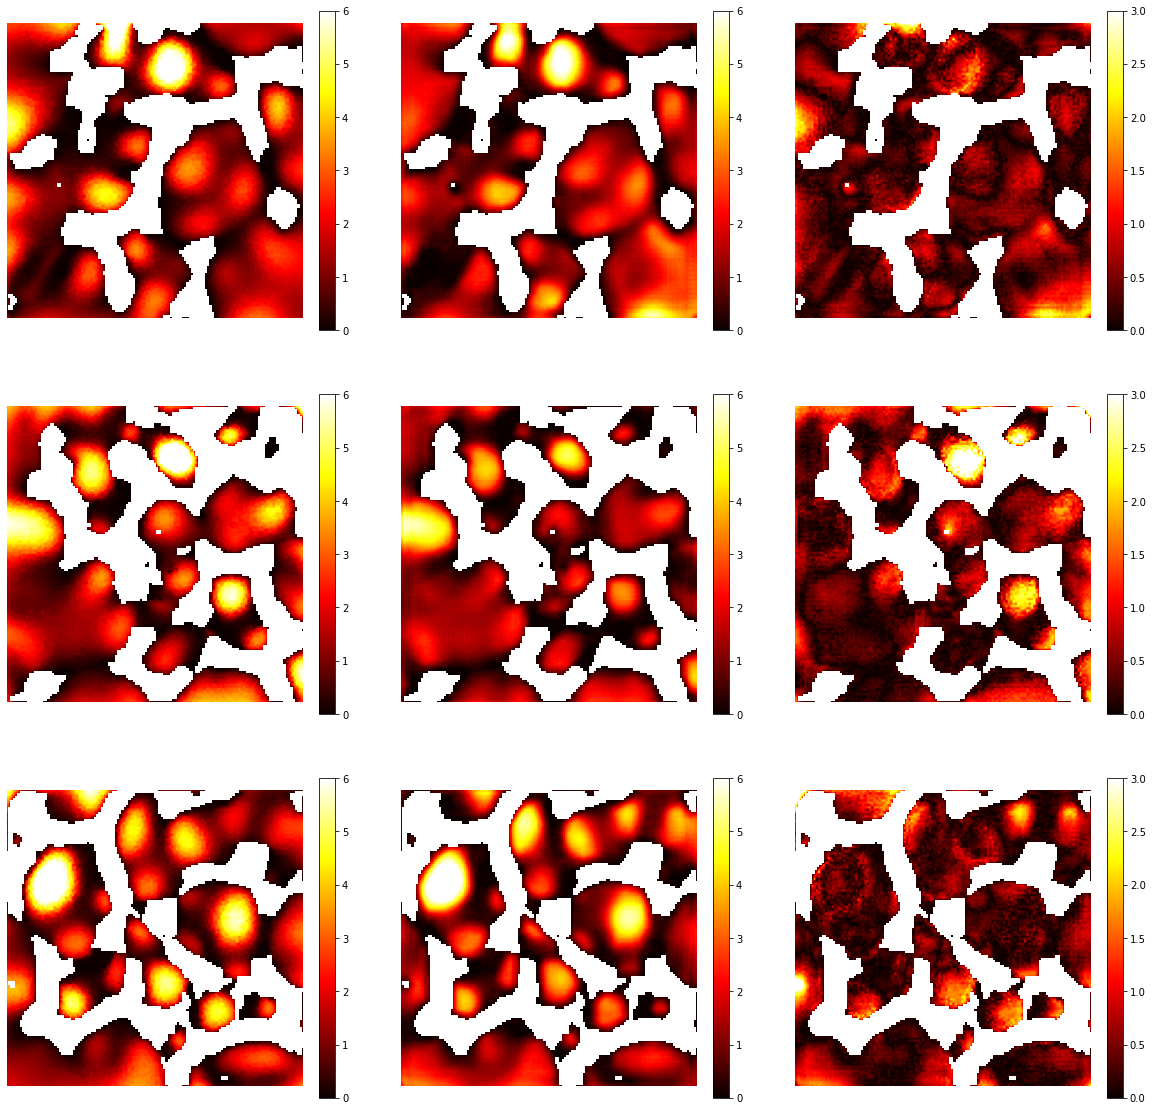

In [ ]:
# Quantitative Visualization of velocity profile (REVISION)
test_sample = 4

mySolid = sic_solid[test_sample,:,:,:,0]
mySolid_mask = np.ma.masked_less(mySolid,1)

myVel_true = sic_vel_norm[test_sample,:,:,:,0]
myVel_true = np.ma.array( myVel_true, mask=np.ma.getmask(mySolid_mask) )

myVel_pred = vz_test_pred[test_sample,:,:,:,0]
myVel_pred = np.ma.array( myVel_pred, mask=np.ma.getmask(mySolid_mask) )

threshold = myVel_true.mean()

#myVel_error = np.abs(np.divide((myVel_true - myVel_pred),myVel_true))*100
myVel_error = np.abs(myVel_true - myVel_pred)

test_slice = np.array( [data_size//4, data_size//2, 3*data_size//4] )

vel_range = (0,6)

fig, axs = plt.subplots( nrows=3, ncols=3,figsize=(20,20) )
for j in range(3):

  im=axs[j,0].imshow(myVel_true[:,:,test_slice[j]], clim=vel_range, cmap=plt.cm.hot)
  fig.colorbar(im,ax=axs[j,0],fraction=0.05)
  axs[j,0].axis('off')

  im=axs[j,1].imshow(myVel_pred[:,:,test_slice[j]], clim=vel_range, cmap=plt.cm.hot)
  fig.colorbar(im,ax=axs[j,1],fraction=0.05)
  axs[j,1].axis('off')

  im=axs[j,2].imshow(myVel_error[:,:,test_slice[j]], clim=(0,3), cmap=plt.cm.hot)
  fig.colorbar(im,ax=axs[j,2],fraction=0.05)
  axs[j,2].axis('off')


In [ ]:
test_sample = 4

mySolid = sic_solid[test_sample,:,:,:,0]
mySolid_mask = np.ma.masked_less(mySolid,1)

myVel_true = sic_vel_norm[test_sample,:,:,:,0]
myVel_true = np.ma.array( myVel_true, mask=np.ma.getmask(mySolid_mask) )

myVel_pred = vz_test_pred[test_sample,:,:,:,0]
myVel_pred = np.ma.array( myVel_pred, mask=np.ma.getmask(mySolid_mask) )

test_slice = np.array( [data_size//4, data_size//2, 3*data_size//4] )
fig_title = ['Quarterpoint', 'Halfpoint', 'Three Quarterpoint']

fig, axs = plt.subplots( nrows=3, ncols=3,figsize=(20,20) )

vel_range = (-4,4)

for j in range(3):

  im=axs[j,0].imshow(mySolid[:,:,test_slice[j]], clim=(0,1), cmap=plt.cm.hot)
  fig.colorbar(im,ax=axs[j,0],fraction=0.05)
  axs[j,0].axis('off')
  axs[j,0].set_title(f'{fig_title[j]} Solid')

  im=axs[j,1].imshow(myVel_true[:,:,test_slice[j]], clim=vel_range, cmap=plt.cm.hot)
  fig.colorbar(im,ax=axs[j,1],fraction=0.05)
  axs[j,1].axis('off')
  axs[j,1].set_title(f'{fig_title[j]} Simulation')

  im=axs[j,2].imshow(myVel_pred[:,:,test_slice[j]], clim=vel_range, cmap=plt.cm.hot)
  fig.colorbar(im,ax=axs[j,2],fraction=0.05)
  axs[j,2].axis('off')
  axs[j,2].set_title(f'{fig_title[j]} Prediction')

In [ ]:
# SAVE X VELOCITY

case_name = (45, 65, 80)

for i in range(6):
    save_name = f'{case_name[i//2]}PPI_domain{i%2+1}_vfieldx'
    scipy.io.savemat( f'Prediction Results/UnitCell Model/{version}/{save_name}.mat', {'vfield_ML': np.squeeze(vz_test_pred[i,:,:,:,0])} )

In [ ]:
# SAVE Y VELOCITY

case_name = (45, 65, 80)

for i in range(6):
    save_name = f'{case_name[i//2]}PPI_domain{i%2+1}_vfieldy'
    scipy.io.savemat( f'Prediction Results/UnitCell Model/{version}/{save_name}.mat', {'vfield_ML': np.squeeze(vz_test_pred[i,:,:,:,0])} )

In [ ]:
# SAVE Z VELOCITY

case_name = (45, 65, 80)

for i in range(6):
    save_name = f'{case_name[i//2]}PPI_domain{i%2+1}_vfield'
    scipy.io.savemat( f'Prediction Results/UnitCell Model/{version}/{save_name}.mat', {'vfield_ML': np.squeeze(vz_test_pred[i,:,:,:,0])} )

# Data Analysis

In [ ]:
# Training data set permeability

train_data_vel_perm = train_data_vel.mean(axis=(1,2,3,4))

train_bins = np.linspace(0, 8, 9)
train_hist = plt.hist( train_data_vel_perm, bins=train_bins, density=False, histtype='step', label='true' )

plt.legend()
plt.xlabel('Permeability')
plt.ylabel('Probability')
plt.show()

print(train_hist[0])
print(train_hist[1])

In [ ]:
# Save histogram
save_name = 'Model A training data'
scipy.io.savemat( f'Prediction Results/UnitCell Model/{save_name}.mat', {'data': train_data_vel_perm} )

In [ ]:
# Training Data PDF

# Velocity PDF
vel_train_flat = np.abs( train_data_vel.flatten() )

min = 0.001
max = 10
numbin = 1000

vel_train_flat_nz = vel_train_flat[ (vel_train_flat > min) ]


lin_bins = np.linspace(min, max, numbin)
train_hist = plt.hist( vel_train_flat_nz, bins=lin_bins, density=True, histtype='step', label='pred' )

plt.legend()
plt.xlabel('Velocity')
plt.ylabel('Probability')
plt.show()

In [ ]:
print(train_hist[0])

In [ ]:
# Save histogram
save_name = 'ModelD_training'

scipy.io.savemat( f'Prediction Results/UnitCell Model/{save_name}_bin_vel{channel}.mat', {'data': train_hist[1]} )
scipy.io.savemat( f'Prediction Results/UnitCell Model/{save_name}_pdf_vel{channel}.mat', {'data': train_hist[0]} )

In [ ]:
# SiC PDF
vel_true_flat = np.abs( sic_vel_norm.flatten() )

min = 0.001
max = 8
numbin = 1000

vel_true_flat_nz = vel_true_flat[ (vel_true_flat > min) ]

lin_bins = np.linspace(min, max, numbin)
true_hist = plt.hist( vel_true_flat_nz, bins=lin_bins, density=True, histtype='step', label='true' )

plt.legend()
plt.xlabel('Velocity')
plt.ylabel('Probability')
plt.show()

In [ ]:
# Save histogram
save_name = 'SiCFoam'

scipy.io.savemat( f'Prediction Results/UnitCell Model/{save_name}_bin_vel{channel}.mat', {'data': true_hist[1]} )
scipy.io.savemat( f'Prediction Results/UnitCell Model/{save_name}_pdf_vel{channel}.mat', {'data': true_hist[0]} )

In [ ]:
!pip install porespy

import porespy as ps

In [ ]:
uc_solid_mis = np.zeros_like(uc_solid_data)

for i in range(uc_solid_data.shape[0]):
  print(i)
  uc_solid_mis[i,:,:,:] = ps.filters.local_thickness(uc_solid_data[i,:,:,:])

In [ ]:
scipy.io.savemat( f'Prediction Results/UnitCell_modelB_mis.mat', {'data': uc_solid_mis} )

In [ ]:
sic_solid_mis = np.zeros_like(sic_solid)

for i in range(sic_solid.shape[0]):
  sic_solid_mis[i,:,:,:] = ps.filters.local_thickness(sic_solid[i,:,:,:])

In [ ]:
scipy.io.savemat( f'Prediction Results/sic_mis.mat', {'data': sic_solid_mis} )